In [1]:
library(tidyverse)
library(tidytext)
library(wordcloud)
library(topicmodels)
library(gridExtra)
library(shiny)
library(textdata)
library(reshape2)
library(rsconnect)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: RColorBrewer


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘textdata’


The following object is masked from ‘package:httr’:

    cache_info



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rsconnect’


The following object is masked from ‘package:shiny’:

    serverInfo




# 1. Overview
The objective is to conduct a comprehensive sentiment analysis of airline tweets, providing valuable insights into customer perceptions and experiences. Utilizing both the dataset's sentiments and the NRC sentiment dictionary, the exploration will encompass sentiment distributions, identification of potential misclassifications, and the discovery of hidden patterns through topic modeling. The accessibility of the findings will be enhanced by developing interactive Shiny apps, enabling users to delve deeper into the data. Beyond mere dataset analysis, there will be an emphasis on the significance of employing diverse sentiment analysis techniques to avoid biases and achieve a more profound understanding of customer sentiments within the airline industry.

The primary purpose of conducting sentiment analysis on airline tweets is to gain valuable insights into how customers perceive and feel about different airlines. By carefully analyzing sentiments expressed in the tweets, the aim is to unveil the overall sentiment distribution for each airline, shedding light on customer experiences. This analysis will have practical applications, including optimizing customer experiences, monitoring and safeguarding brand reputation, conducting comprehensive competitor analysis, proactively managing potential crises, conducting well-informed market research, and employing targeted customer segmentation. Such a Sentiment analysis would empower airlines to make informed, data-driven decisions, leading to enhanced customer satisfaction and a competitive edge in the dynamic airline industry.

# 2. Data Preparation

In [2]:
# Load Data
tweets = read_csv("/kaggle/input/tweets/Tweets-1.csv")
head(tweets)
#Tokenize and Remove Stop Words

custom_stop_words <- tribble(
  # Column names should match stop_words
  ~word, ~lexicon,
  # Add http, win, and t.co as custom stop words
  "http", "CUSTOM",
  "win", "CUSTOM",
  "t.co", "CUSTOM",
  "virginamerica", "CUSTOM",
  "sfo", "CUSTOM",
  "united", "CUSTOM",
  "southwestair", "CUSTOM",
  "americanair", "CUSTOM",
  "usairways","CUSTOM",
  "jetblue","CUSTOM",
  "flight", "CUSTOM",
  "flights","CUSTOM",
  "airline","CUSTOM",
  "fly","CUSTOM",
  "guys","CUSTOM"
)
# Bind the custom stop words to stop_words
stop_words2 <- stop_words %>% 
   bind_rows(custom_stop_words)
#
tidy_twitter <- tweets %>% 
  
  select_if(~!any(is.na(.)))  %>% 
  # Tokenize the twitter data
  unnest_tokens(word, text) %>% 
  # Remove stop words
  anti_join(stop_words2) %>%
  # Remove incoherent words and numbers using grepl
  filter(!grepl("\\b\\d+\\b|[^[:alpha:]]", word)) %>%
 
  filter(nchar(word) > 2)

Rows: 14640 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): airline_sentiment, negativereason, airline, airline_sentiment_gold...
dbl  (4): tweet_id, airline_sentiment_confidence, negativereason_confidence,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
5.70306e+17,neutral,1.0000,NA,NA,Virgin America,NA,cairdin,NA,0,@VirginAmerica What @dhepburn said.,NA,2/24/2015 11:35,NA,Eastern Time (US & Canada)
5.70301e+17,positive,0.3486,NA,0.0000,Virgin America,NA,jnardino,NA,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NA,2/24/2015 11:15,NA,Pacific Time (US & Canada)
5.70301e+17,neutral,0.6837,NA,NA,Virgin America,NA,yvonnalynn,NA,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NA,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
5.70301e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NA,jnardino,NA,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NA,2/24/2015 11:15,NA,Pacific Time (US & Canada)
5.70301e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NA,jnardino,NA,0,@VirginAmerica and it's a really big bad thing about it,NA,2/24/2015 11:14,NA,Pacific Time (US & Canada)
5.70301e+17,negative,1.0000,Can't Tell,0.6842,Virgin America,NA,jnardino,NA,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA,NA,2/24/2015 11:14,NA,Pacific Time (US & Canada)


Joining with `by = join_by(word)`


# 2. Data Investigation without using an External Sentiment Dictionary

airline_sentiment,n
<chr>,<int>
negative,59677
neutral,14062
positive,10474


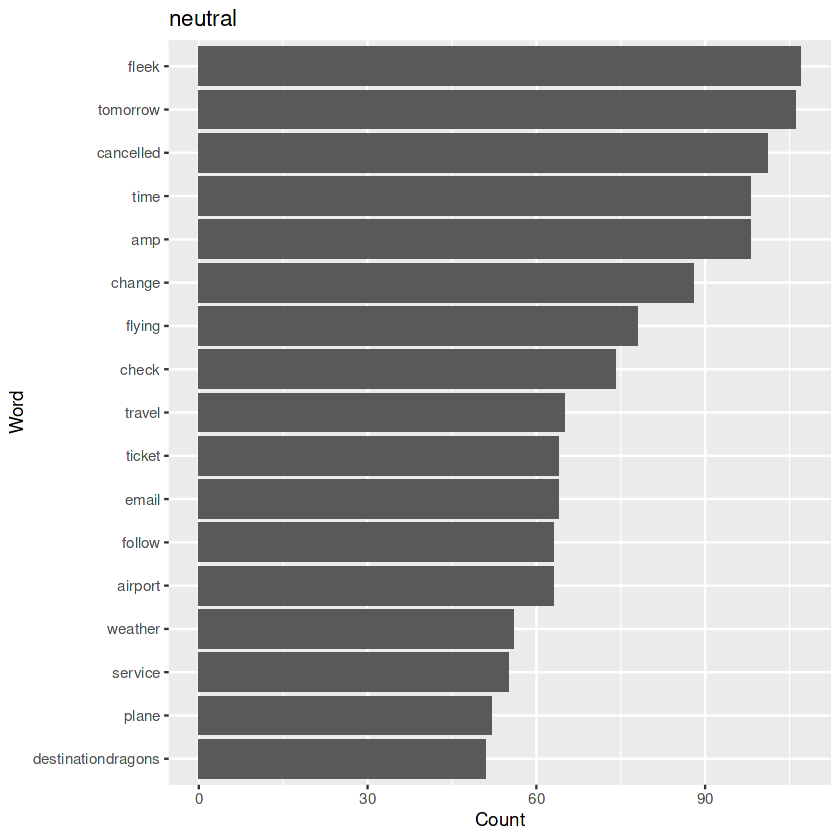

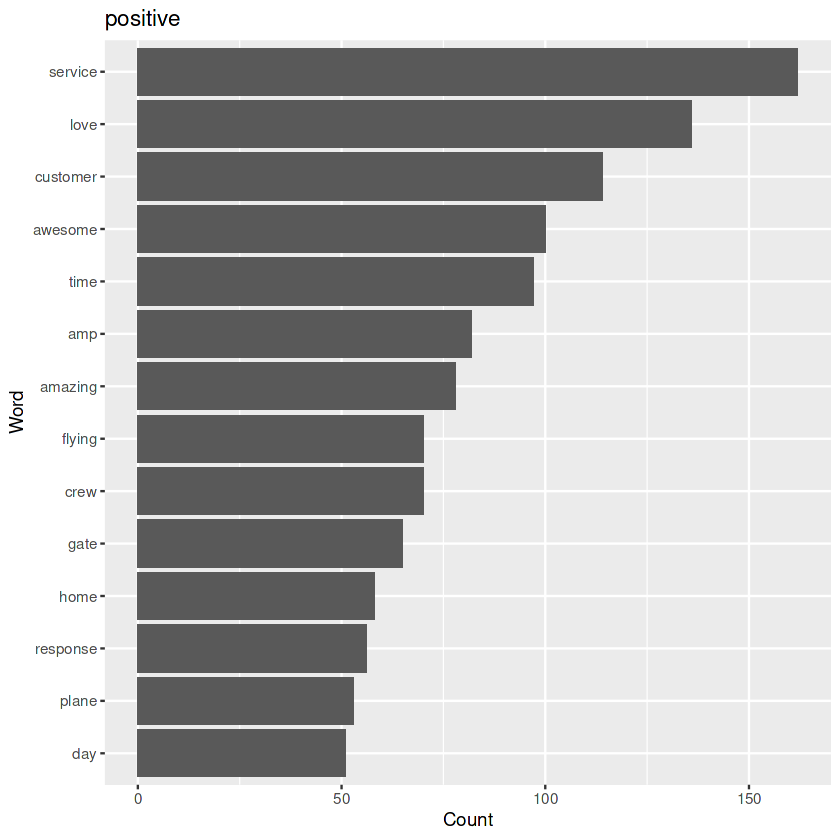

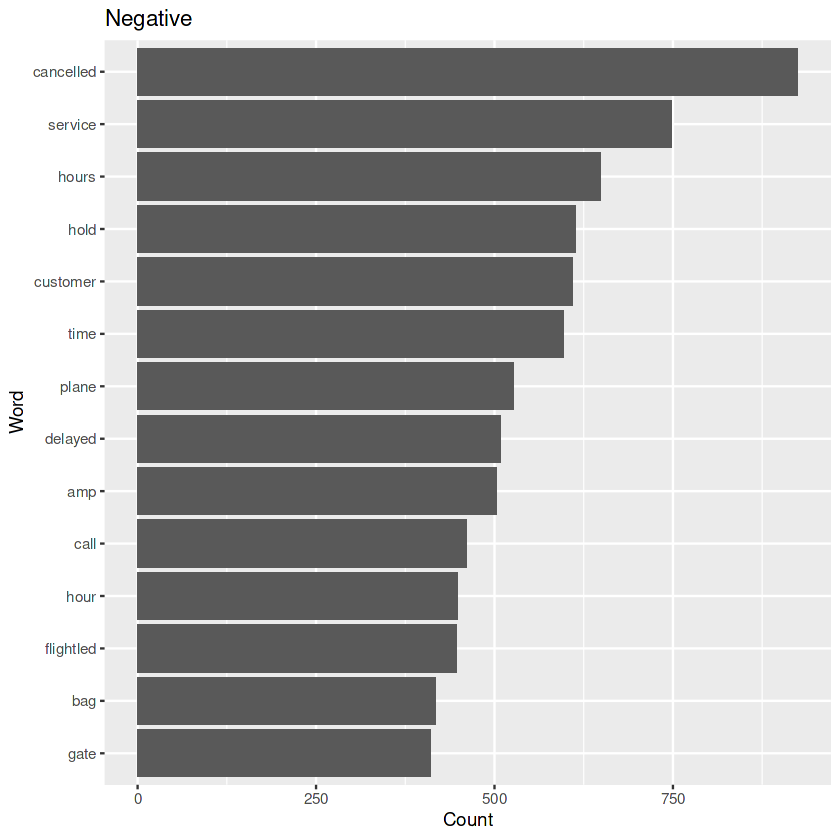

airline,n
<chr>,<int>
American,16141
Delta,11160
Southwest,13338
US Airways,18109
United,22826
Virgin America,2639


`summarise()` has grouped output by 'airline'. You can override using the
`.groups` argument.


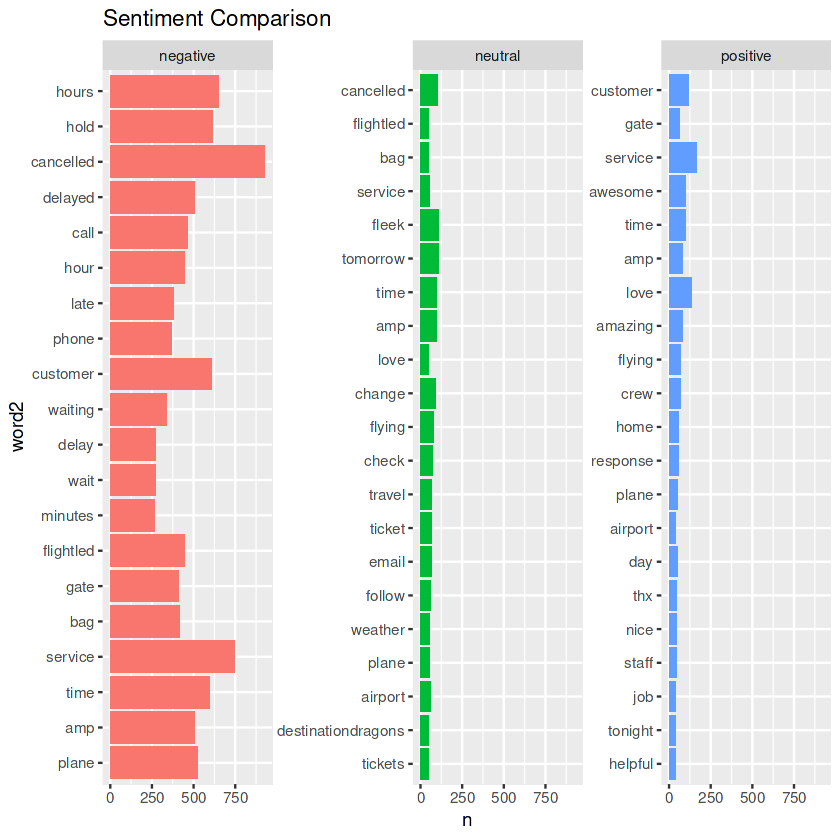

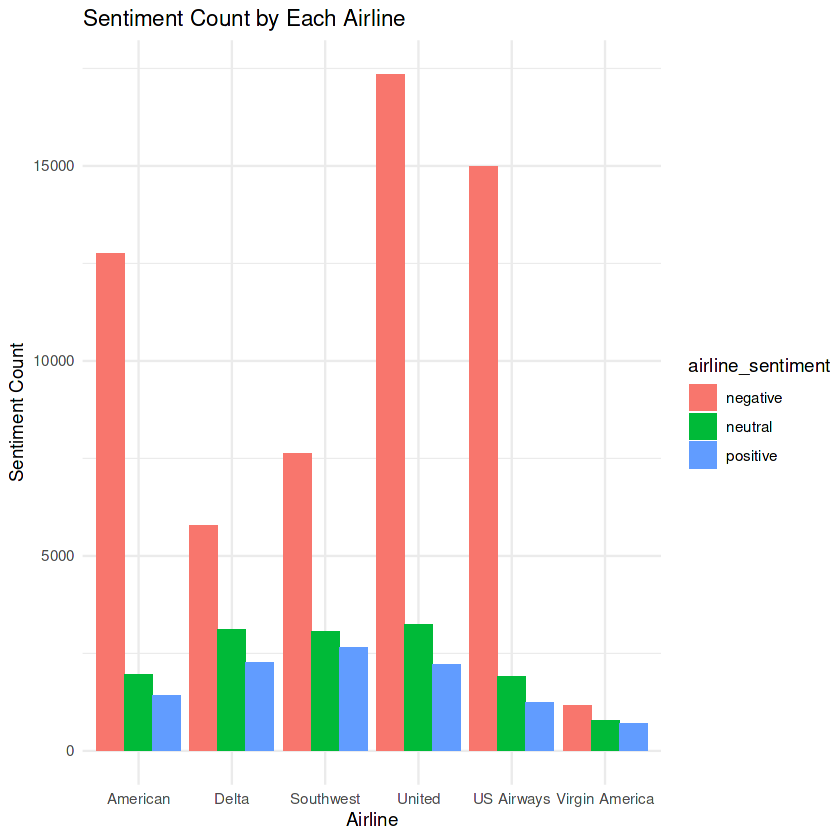

In [3]:
#General sentiment count
tidy_twitter %>% count(airline_sentiment)

#Most frequent words in neutral
word_counts <- tidy_twitter %>% 
  filter(airline_sentiment == "neutral") %>% 
  count(word) %>%  
  filter(n > 50) %>% 
  arrange(desc(n))  

ggplot(word_counts, aes(reorder(word, n), n)) +
  geom_col() +
  coord_flip() +
  labs(x = "Word", y = "Count")+ggtitle("neutral")

#Most frequent words in Positive
word_counts <- tidy_twitter %>% 
  filter(airline_sentiment == "positive") %>% 
  count(word) %>%  
  filter(n > 50) %>% 
  arrange(desc(n))  

ggplot(word_counts, aes(reorder(word, n), n)) +
  geom_col() +
  coord_flip() +
  labs(x = "Word", y = "Count")+ggtitle("positive")

#Most frequent words in negative
word_counts <- tidy_twitter %>% 
  filter(airline_sentiment == "negative") %>% 
  count(word) %>%  
  filter(n > 400) %>% 
  arrange(desc(n))  

ggplot(word_counts, aes(reorder(word, n), n)) +
  geom_col() +
  coord_flip() +
  labs(x = "Word", y = "Count")+ggtitle("Negative")

# Top 20 Sentiments compared
word_counts <- tidy_twitter %>%
  # Count words by whether or not its a complaint
  count(word, airline_sentiment) %>%
  # Group by whether or not its a complaint
  group_by(airline_sentiment) %>%
  # Keep the top 20 words
  slice_max(n, n = 20) %>%
  # Ungroup before reordering word as a factor by the count
  ungroup() %>%
  mutate(word2 = fct_reorder(word, n))

ggplot(word_counts, aes(x = word2, y = n, fill  = airline_sentiment)) +
  # Don't include the lengend for the column plot
  geom_col(show.legend = FALSE) +
  # Facet by whether or not its a complaint and make the y-axis free
  facet_wrap(~airline_sentiment, scales = "free_y") +
  # Flip the coordinates and add a title: "Twitter Word Counts"
   coord_flip() +
   ggtitle("Sentiment Comparison") 
#Frequency od tweets for each airline 
tidy_twitter %>% count(airline)
#Sentiment Count by Each Airline
aa_count <- tidy_twitter %>%
  group_by(airline, airline_sentiment) %>%
  summarise(count = n()) %>%
  ungroup()

ggplot(aa_count, aes(x = airline, y = count, fill = airline_sentiment)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Airline", y = "Sentiment Count", title = "Sentiment Count by Each Airline") +
  theme_minimal()

3 graphs are created to highlight the frequency of each of the sentiments and an additional graph puts them all together for a better visual comparison. The 3 sentiments in the base dataset are positive, negative and neutral. "Negative" sentiment has the most words associated with it (60434), followed by "neutral" (14210) and "positive" (10728). Initial observations made using the graphs suggests that most of the words have been miscategorized. For example "negative" contains words such as gate, customer or hour that are not necessarily negative words. This appears to be the case for "neutral" and "positive" as well. Since there are only 3 sentiments, most of the words are being overgeneralized and put into categories they do not belong in. Therefore accurate conclusions cannot be drawn from the sentiments provided in the base data set. There are 6 airlines in total. American, Delta and Southwest Airlines have the most number of tweets about them. However, United has the most negative tweets about them, followed by US airways and American. Judging from the data Delta appears to have the best sentiments about them. They are not only one of the most tweeted about airlines but there have very little "negative" sentiment attached to their names. As mentioned before, this might not be an accurate representation of the sentiments given the nature of the data. 

# 3. Word Cloud

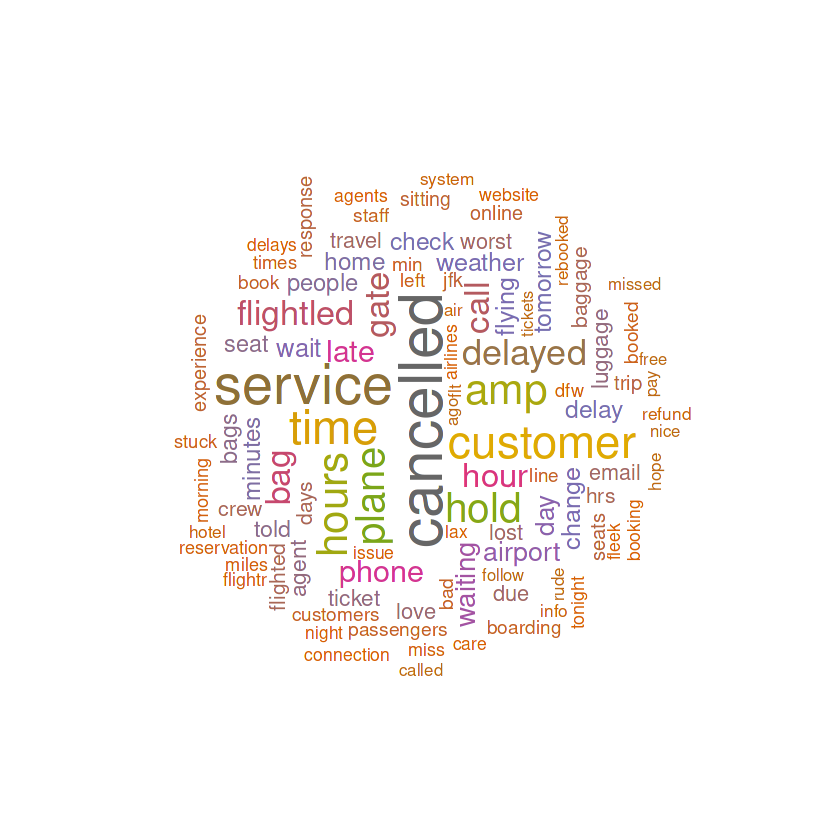

In [4]:
#Word Cloud
word_counts <- tidy_twitter %>% 
  count(word)

# Define the color palette with more interpolated colors
color_palette <- colorRampPalette(brewer.pal(8, "Dark2"))(100)

wordcloud(
  words = word_counts$word,
  freq = word_counts$n,
  max.words = 100,
  colors = color_palette,
  random.order = FALSE,
  rot.per = 0.35,
  scale = c(3, 0.5)
)

# 4. Introducing a Sentiment Dictionary
A sentiment dictionary is a lexicon containing words or phrases, each linked to specific sentiments or emotions, like positive, negative, or neutral. It helps classify text data based on the emotions conveyed in the words, aiding sentiment analysis tasks in natural language processing and text analysis.

Rows: 13901 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): word, sentiment

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(word)`
Warning message in inner_join(., nrc_lexicon):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 7 of `x` matches multiple rows in `y`.
ℹ Row 987 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


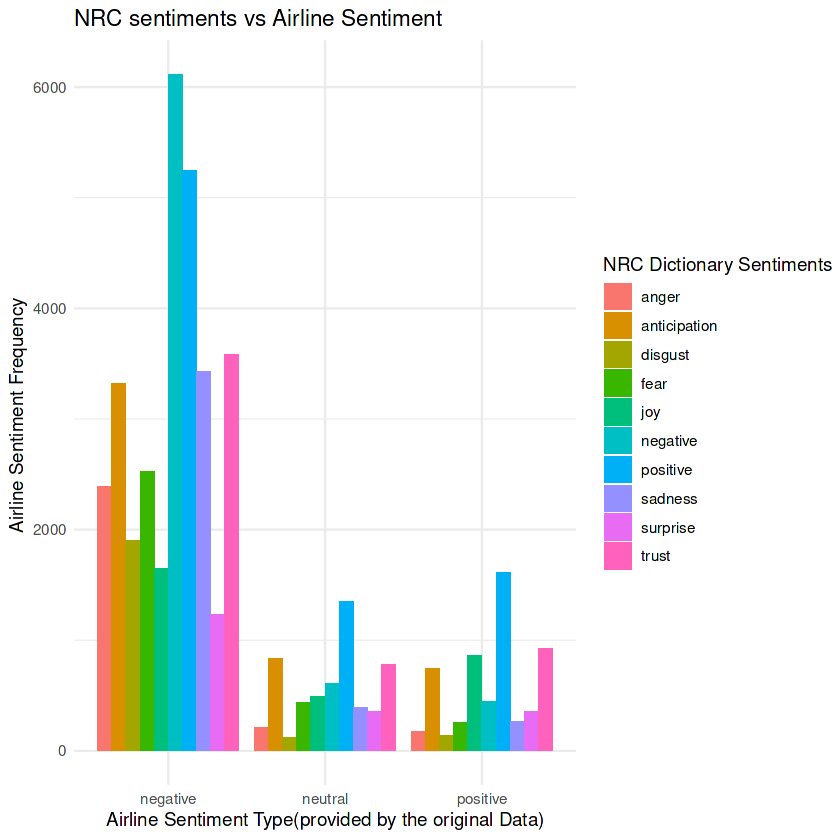

In [5]:
#Sorting the original data using the dictionary

nrc_lexicon <- read_csv("/kaggle/input/bing-nrc-afinn-lexicons/NRC.csv")
sentiment_twitter <- tidy_twitter %>% 
  inner_join(nrc_lexicon)
 

  # Count by complaint label and sentiment
 count1 = sentiment_twitter  %>% count(airline_sentiment, sentiment) %>% 
  # Spread the sentiment and count columns
  pivot_wider(names_from = sentiment,values_from = n)

#The words in the dataframe are grouped by the sentiments Potitive, negative and neutral. The graph shows how many of the NRC sentiment words are in the original sentiments (Load sentiment_melted dataframe for more context)
sentiment_melted <- count1 %>%
  pivot_longer(cols = -airline_sentiment, names_to = "sentiment", values_to = "count")

# Create a bar plot
ggplot(sentiment_melted, aes(x = airline_sentiment, y = count, fill = sentiment)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Airline Sentiment Type(provided by the original Data)", y = "Airline Sentiment Frequency ", title = "NRC sentiments vs Airline Sentiment", fill = "NRC Dictionary Sentiments") +
  theme_minimal()

#Since there are more categories in NRC sentiment Dictionary, the distribution of positive and negative words are different in sentiment_twitter df as compared to the original data frame, tidy_twitter. According to the original sentiments provided by the airline_sentiment column (in tidy_twitter df), there are more negative words than positive words. However according to the NRC dictionary (sentiment_twitter df), positive words have the most frequency. This is just an illusion because in both these data frames, sentiments are categorized differently. NRC dictionary has a lot more categories, thus splitting the original negative words list into more categories. Another reason this is happening is because the sentiment_twitter df is half the size of the original dataframe.There's a graph below highlighting the discrepancy 


# 5. Further Investigation of the Discrepancy 

`summarise()` has grouped output by 'airline'. You can override using the
`.groups` argument.


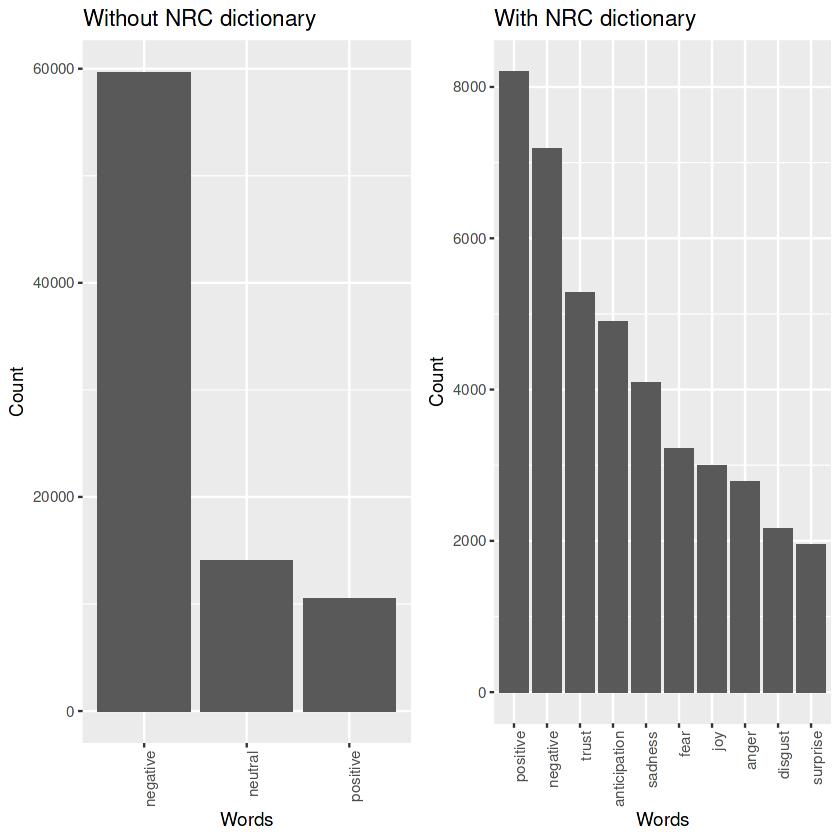

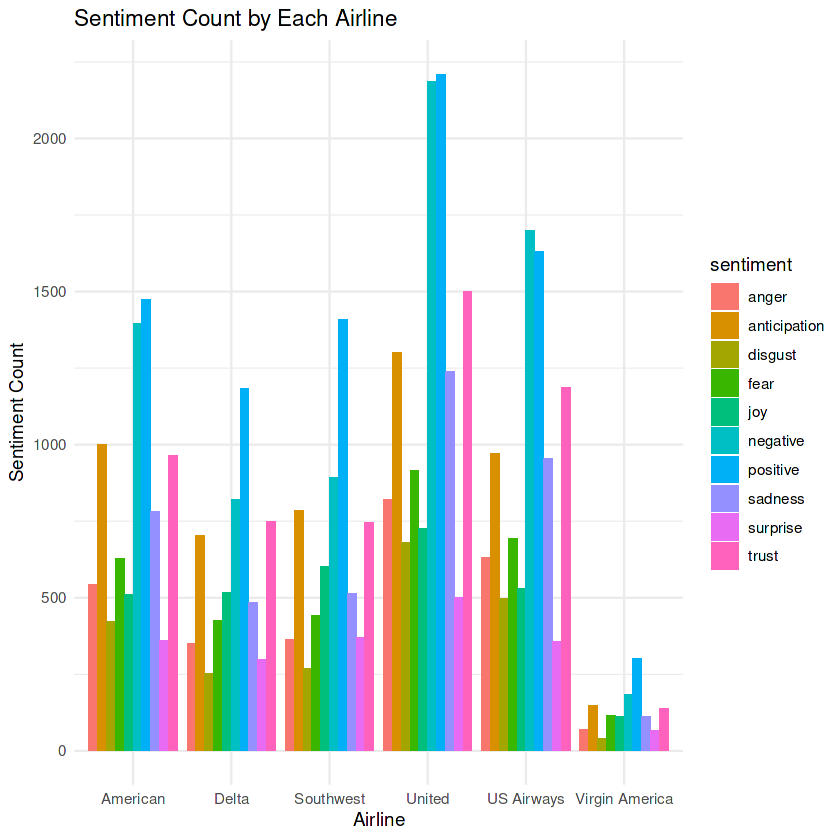

In [6]:
word_count <- tidy_twitter %>% 
  count(airline_sentiment, sort = TRUE)

# Create a simple ggplot of word count
g1 = ggplot(word_count, aes(x = airline_sentiment, y = n)) +
  geom_col() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "Words", y = "Count") +
  ggtitle("Without NRC dictionary")

###
word_count1 <- sentiment_twitter %>% 
  count(sentiment) %>%
  arrange(desc(n))

# Create a simple ggplot of word count in descending order
g2 = ggplot(word_count1, aes(x = reorder(sentiment, -n), y = n)) +
  geom_col() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "Words", y = "Count") +
  ggtitle("With NRC dictionary")

grid.arrange(g1,g2,ncol = 2)

#NRC Sentiment count by Each airline

ab_count <- sentiment_twitter %>%
  group_by(airline, sentiment) %>%
  summarise(count = n()) %>%
  ungroup()

ggplot(ab_count, aes(x = airline, y = count, fill = sentiment)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Airline", y = "Sentiment Count", title = "Sentiment Count by Each Airline") +
  theme_minimal()

When using an NRC dictionary, the graph shows that a large portion of the words in "negative" in the tweets data frame are actually categorized as "positive" inside the NRC (external) dictionary. Since there are more categories in NRC sentiment Dictionary, the distribution of positive and negative words are different in the new dataframe called sentiment_twitter. According to the original sentiments provided by the airline_sentiment column (in tidy_twitter df), there are more negative words than positive words. However according to the NRC dictionary (sentiment_twitter df), positive words have the most frequency. This is just an illusion because in both these data frames, sentiments are categorized differently. NRC dictionary has a lot more categories. As stated, the original data only has 3 categories while the sentiment dictionary has 10. The words in "negative" sentiment, therefore gets split into more categories. Another reason for this observation is because the sentiment_twitter dataframe is half the size of the original dataframe, making the distribution of the words different. When a sentiment count is done using the NRC dictionary, we observe that United has the most tweets associated with the sentiments "positive", "trust" and "joy", significantly more than all other airlines. Both graphs show Virgin America as the least talked about airline. By visualizing the data, we can observe that even though united airlines had the most negative words associated with them (according to the original dataset), NRC concludes that United is not only the most talked about but also the most trusted and well performing of all the airlines. 

# 6. Topic Modeling and Pattern Analysis

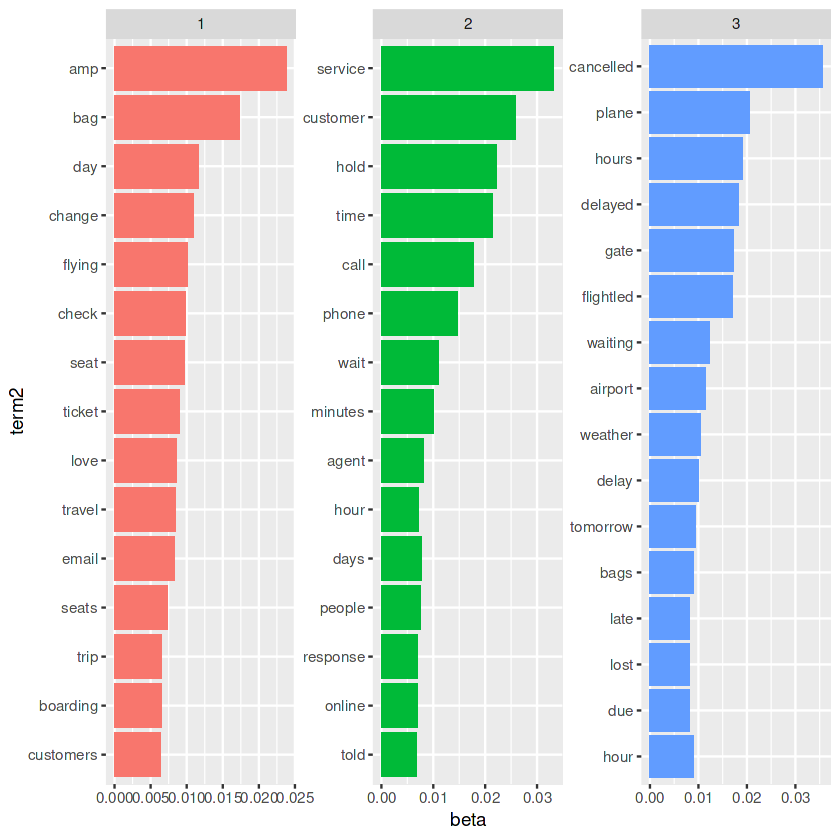

In [7]:
#Topic modeling is a probabilistic model used to extract hidden patterns in a large collection of text. 

dtm_twitter <- tidy_twitter %>% 
  count(word, tweet_id) %>% 
  # Cast the word counts by tweet into a DTM
  cast_dtm(tweet_id, word, n)

# Coerce dtm_twitter into a matrix called matrix_twitter
matrix_twitter <- as.matrix(dtm_twitter)

##
lda_out2 <- LDA(
  dtm_twitter,  k = 3,  method = "Gibbs",
  control = list(seed = 42)
)

# Tidy the matrix of word probabilities
lda_topics2 <- lda_out2 %>%   tidy(matrix = "beta")



#
word_probs2 <- lda_topics2 %>% 
  group_by(topic) %>% 
  slice_max(beta, n = 15) %>% 
  ungroup() %>%
  mutate(term2 = fct_reorder(term, beta))

# Plot word probs, color and facet based on topic
ggplot(
  word_probs2, 
  aes(term2, beta, fill = as.factor(topic))
) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()


Topic modelling a technique used to extract hidden patterns from data. Therefore using topic modelling on airline tweets could let us know about patterns of sentiment most prevalent in the entire data. 3 topic modelling graphs have been created, each displaying words that have a high probability of being related to a particular "topic". This means that each graph is showing words that have a tendency to show up together in the data. 

In topic 1 or the first graph, the top words are amp, bag, day, change, flying. It seems to be related to general travel experiences, including flying, luggage, and day-to-day activities. In topic 2 the top words are service, customer, hold, time, call. This topic appears to be focused on customer service experiences, particularly involving communication with the airline (e.g., being on hold, making phone calls). 

In topic 3 the top words are cancelled, plane, hours, delayed, gate. The third topic seems to be about flight disruptions, such as cancellations, delays, and issues related to the airport gates. The beta value represents the probability of a word occurring in a particular topic. Higher beta values indicate that the term is more connected to that topic. For example, in Topic 1, the term "amp" has the highest beta value (0.023875459), which means it is the most relevant word in this topic. However, "amp" is likely a data artifact in the original text and might not convey meaningful information about the topic. We can then focus on the next most relevant terms, such as "bag" and "day," which provide more context to the topic.

In our analysis, it can be concluded that the three topics cover various aspects of airline experiences: general travel (Topic 1), customer service (Topic 2), and flight disruptions (Topic 3). These topics can provide insights into the main concerns and discussions related to airlines in the dataset. However, it's important to note that may not always align perfectly with human interpretation.

# 7. Shiny Apps

In [8]:
ui <- fluidPage(
  titlePanel("Airline Sentiment Analysis"),
  
  sidebarLayout(
    sidebarPanel(
      selectInput("x_axis", "Choose X-axis variable:",
                  choices = c("word", "airline_sentiment"),
                  selected = "word"),
      selectInput("y_axis", "Choose Y-axis variable:",
                  choices = c("n"),
                  selected = "n"),
      conditionalPanel(
        condition = "input.x_axis == 'word'",
        actionButton("word_cloud", "Show Word Cloud")
      )
    ),
    
    mainPanel(
      plotOutput("sentimentPlot"),
      plotOutput("wordCloudPlot", height = "400px")
    )
  )
)


In [9]:
server <- function(input, output) {
  
  output$sentimentPlot <- renderPlot({
    
    if (input$x_axis == "word") {
      word_counts <- tidy_twitter %>%
        count(word, airline_sentiment) %>%
        filter(n > 100) %>%
        arrange(desc(n)) %>%
        head(100)
      
      ggplot(word_counts, aes_string(x = input$x_axis, y = input$y_axis, fill = "airline_sentiment")) +
        geom_col() +
        coord_flip() +
        labs(x = input$x_axis, y = input$y_axis)
    } else {
      sentiment_counts <- tidy_twitter %>%
        count(airline_sentiment) %>%
        arrange(desc(n))
      
      ggplot(sentiment_counts, aes_string(x = input$x_axis, y = input$y_axis)) +
        geom_col() +
        labs(x = input$x_axis, y = input$y_axis)
    }
  })
  
  output$wordCloudPlot <- renderPlot({
    if (input$word_cloud > 0) {
      word_counts <- tidy_twitter %>%
        count(word) %>%
        head(100)
      
      color_palette <- colorRampPalette(brewer.pal(8, "Dark2"))(300)
      
      wordcloud(
        words = word_counts$word,
        freq = word_counts$n,
        max.words = 100,
        colors = color_palette,
        random.order = FALSE,
        rot.per = 0.35,
        scale = c(3, 0.5)
      )
    } else {
      return(NULL)
    }
  })
}

In [10]:
#shinyApp(ui = ui, server = server)

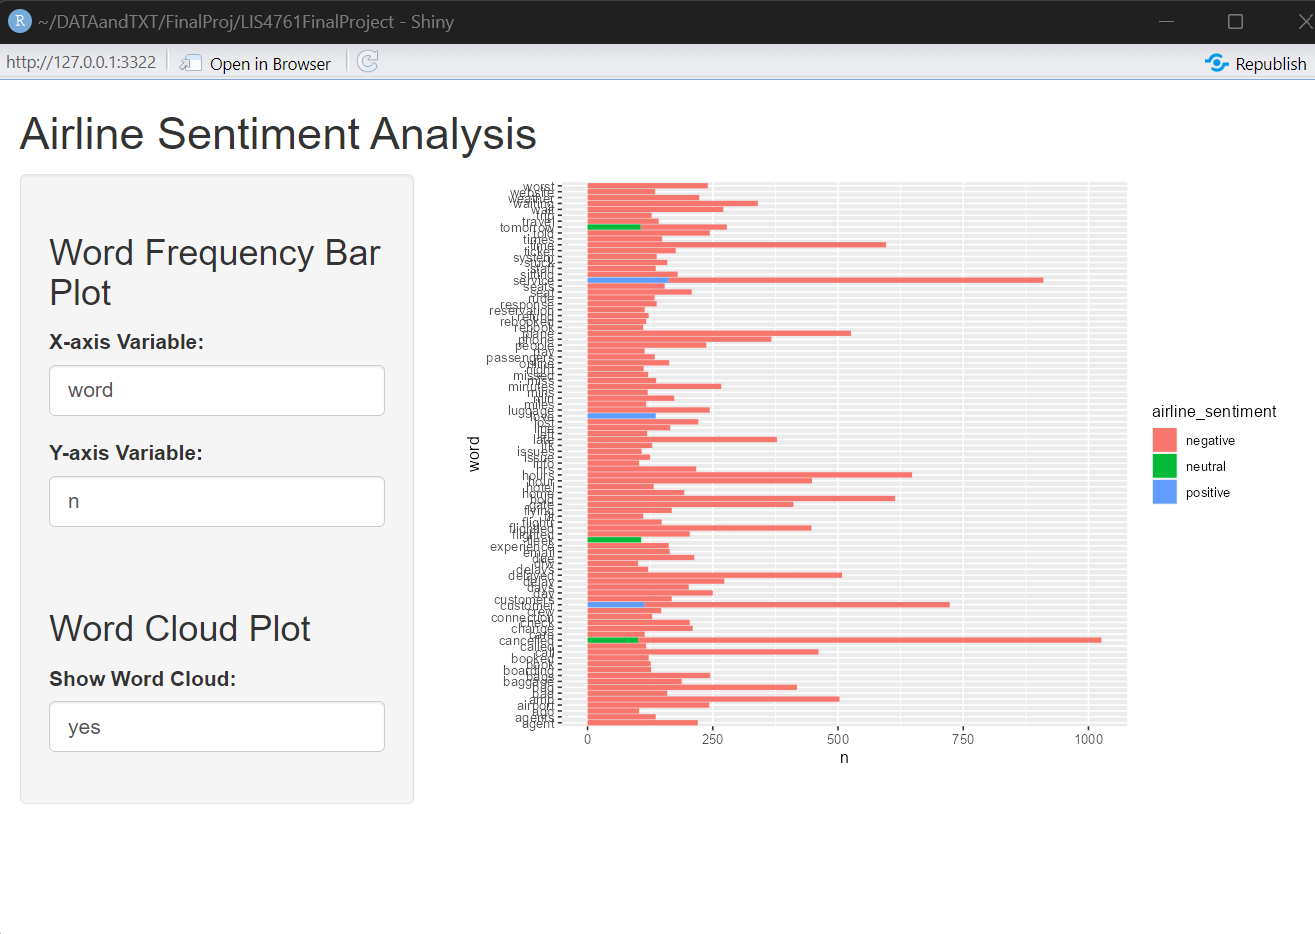

In [11]:
ui2 <- fluidPage(
  titlePanel("Sentiment Twitter Analysis"),
  
  sidebarLayout(
    sidebarPanel(
      h3("Sentiment Analysis based on NRC Dictionary"),
      selectInput("x_axis2", "Choose X-axis variable:",
                  choices = c("word", "sentiment"),
                  selected = "word"),
      selectInput("y_axis2", "Choose Y-axis variable:",
                  choices = c("sentiment", "word"),
                  selected = "sentiment")
    ),
    
    mainPanel(
      plotOutput("sentimentBarPlot2")
    )
  )
)

In [12]:
server2 <- function(input, output) {
  
  output$sentimentBarPlot2 <- renderPlot({
    
    if (input$x_axis2 == "word") {
      top_words <- sentiment_twitter %>%
        count(word, sentiment) %>%
        group_by(sentiment) %>%
        top_n(20, n) %>%
        ungroup()

      ggplot(top_words, aes(x = reorder(word, n), y = n, fill = sentiment)) +
        geom_col() +
        coord_flip() +
        labs(x = "Word", y = "Count") +
        facet_wrap(~ sentiment, scales = "free_y")
    } else {
      sentiment_counts <- sentiment_twitter %>%
        count(sentiment) %>%
        arrange(desc(n))

      ggplot(sentiment_counts, aes(x = sentiment, y = n)) +
        geom_col() +
        labs(x = "Sentiment", y = "Count")
    }
  })
}

In [13]:
#shinyApp(ui = ui2, server = server2)

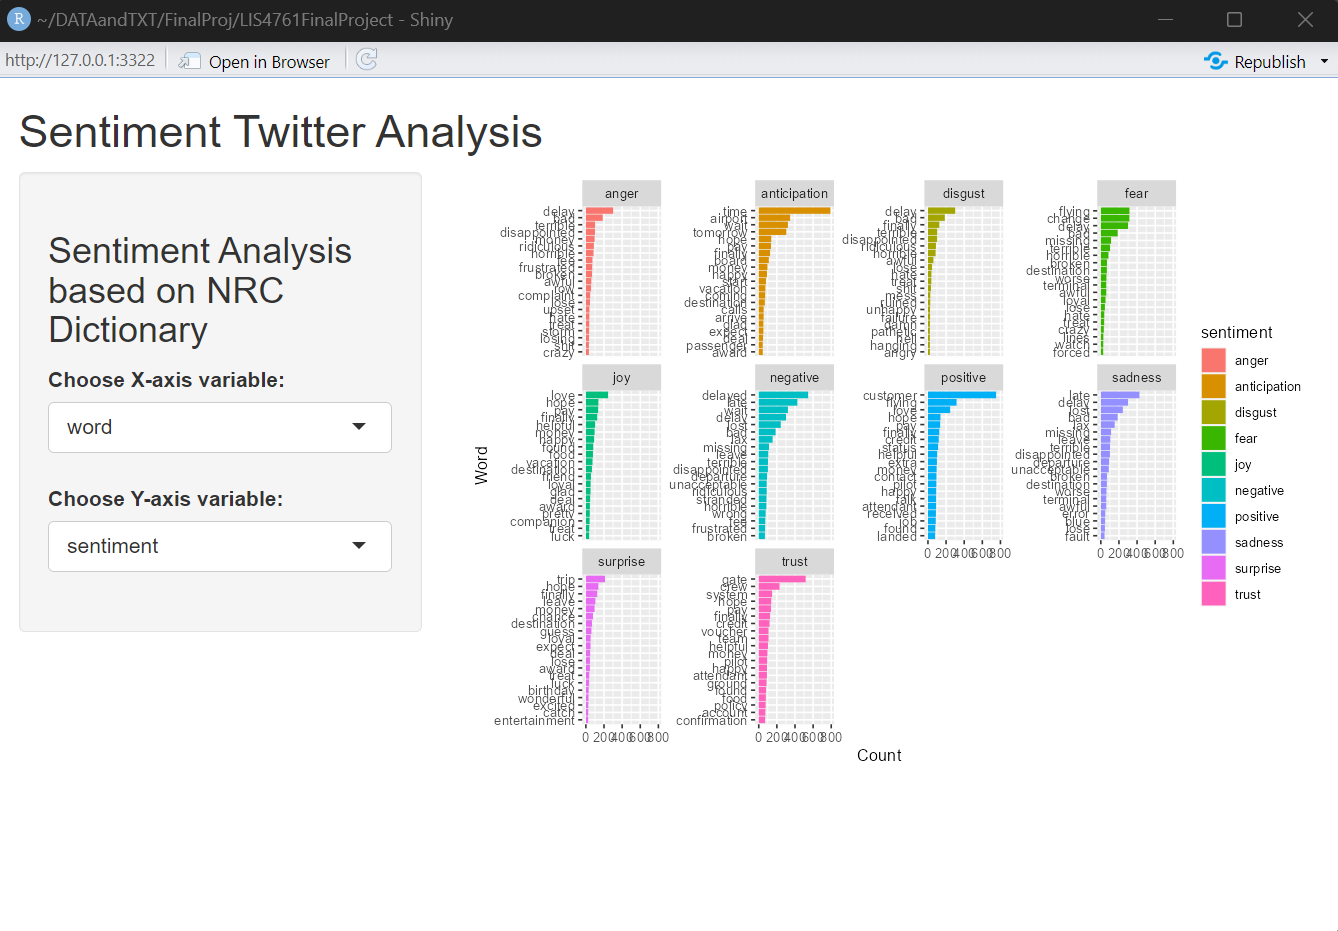
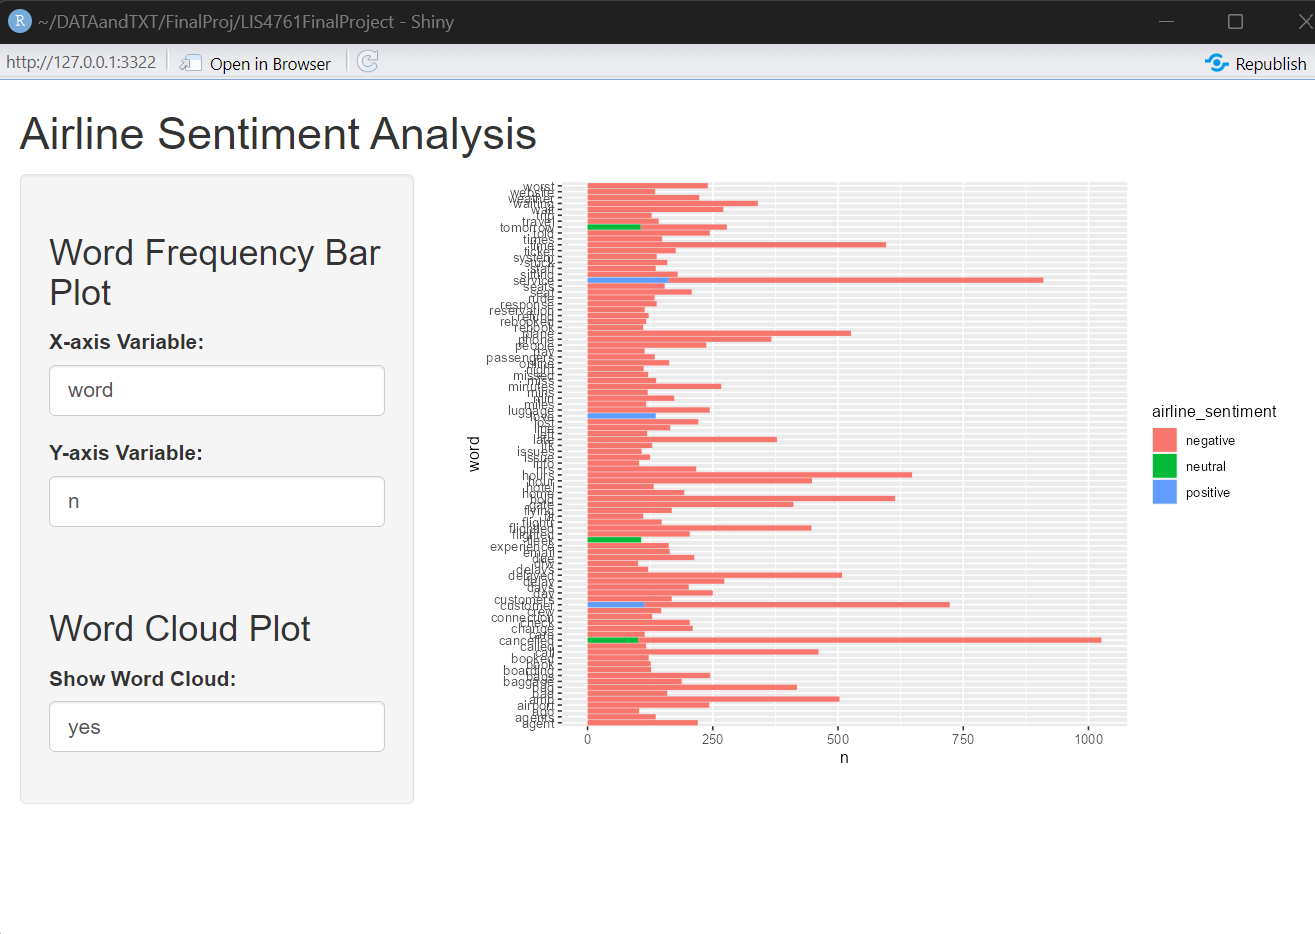

The shiny apps are tools that build on the insights we've gathered from our previous analyses. The first app presents a word frequency graph based on the original dataset, allowing users to explore the most common words in each sentiment category. Users can also adjust the x-axis value to display only the frequencies of the original sentiment categories. The second shiny app looks into the NRC data, offering a closer look at how words are distributed within each NRC sentiment. It creates individual graphs for each sentiment category, placing the word frequencies side by side for simple comparison. For example, we can see that words like "delay" and "fee" are closely associated with the "anger" sentiment, while words such as "helpful" and "attendant" are linked to positive emotions. By altering the x-axis value, users can view a traditional frequency graph that highlights the NRC sentiment distribution. These tools allow us to understand the connections between words and sentiments in the dataset. Analyses such as these provide valuable insights for researchers, marketers, and airlines aiming to enhance customer experiences. Moreover, these visualizations emphasize the need for various sentiment analysis methods to or event potential misinterpretations and biases in the data.